# 토크나이저 비교분석

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?  
코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가? 


In [81]:
s.DecodeIds(train['encoded'][0])

'아 더빙.. 진짜 짜증나네요 목소리 ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ '

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?  
SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.  

DLThon에서 사용했던 트랜스포머 인코더를 활용한 자연어 처리 모델로 분류를 하였습니다.  
매개변수는 그냥 DLThon에서 사용했던 것 그래도 사용했습니다.  
==> valid_acc(test accuracy)가 0.8514달성 

```ptthon
Epoch 4/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2487 - accuracy: 0.8926 - val_loss: 0.3866 - val_accuracy: 0.8514
```



3. SentencePiece의 성능을 다각도로 비교분석하였는가?  
SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였습니다.

mecab과 sentence piece의 bpe 옵션으로 비교하였는데, 유의미한 차이가 없었습니다.  
이론적으로는 sentence piece가 더 좋아야 하는데, 결과를 보고 생각을 하니, mecab의 성능 역시 뛰어나거나, 2진분류라는 태스크가 sentence piece 정도의 고도의 토큰화가 필요한 복잡한 작업이 아니라서 그런거 같습니다.  

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

%matplotlib inline

## 노드 실습



### 데이터 
> https://github.com/jungyeul/korean-parallel-corpora  

형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터  
한국어-영어 병렬을 이루는 말뭉치

In [2]:
path_to_file = 'data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


#### 문장 길이 분석

In [3]:
def print_dist(data, return_sentence_length=False):
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in data:
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length

    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len // len(data))

    sentence_length = np.zeros((max_len), dtype=int)

    for sen in data:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()
    
    if return_sentence_length: 
        return sentence_length

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


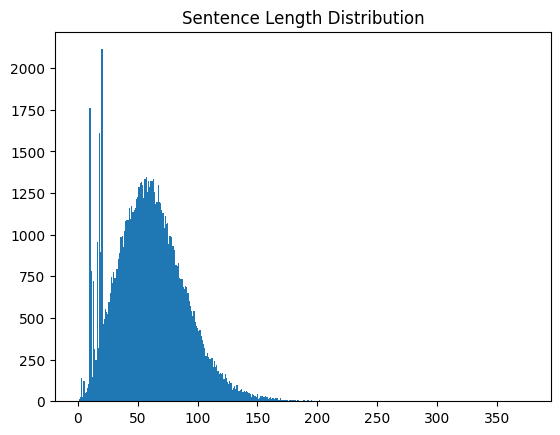

In [4]:
sentence_length = print_dist(raw, True)

길이 1인 데이터 확인

In [5]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


길이가 매우 긴 문장 확인

In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [7]:
# check_sentence_with_length(raw, 11)
# => 중복되는 데이터 많음

#### 중복 데이터 제거 후 분포

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


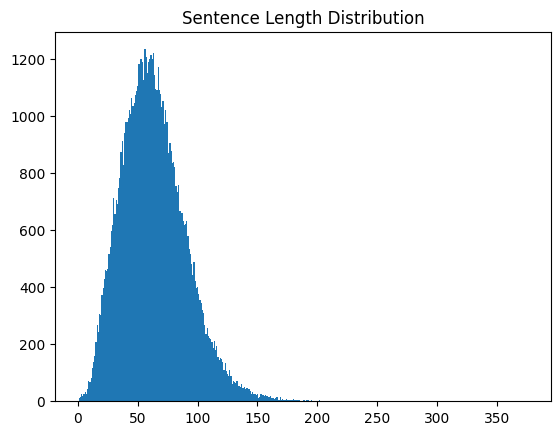

In [8]:
cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))
print_dist(cleaned_corpus)

길이가 10~150인 데이터만 사용

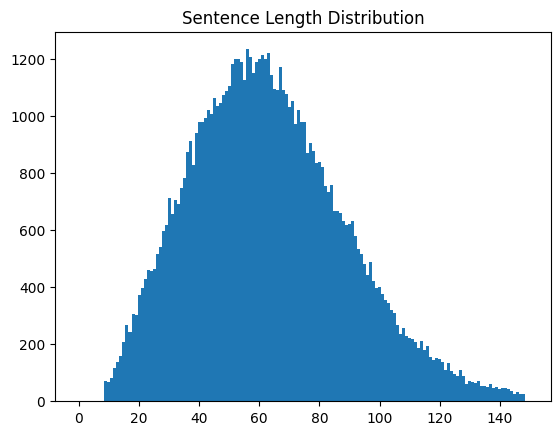

In [9]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 공백 기반 토큰화

In [10]:
def tokenize(corpus):  
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [11]:
# 모든 문장 합치기
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [12]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [13]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


### KoNLPy - MeCab

윈도우에서 konlpy-mecab 지원하지 않음  
`pip install python-mecab-ko`으로 설치

In [14]:
from mecab import MeCab 

mecab = MeCab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [15]:
# 형태소로 나누고 문장 합침
def mecab_split(sentence):
    return mecab.morphs(sentence)
 
mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [16]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


decode

In [17]:
text = mecab_tensor[100]

In [18]:
mecab_tokenizer.sequences_to_texts([text])

['1990 년 대 에 는 10 대 임신 과 출산 률 이 감소 하 긴 했 지만 , 여전히 미국 은 여타 비교 가 될 만 한 국가 들 중 에서 가장 높 은 임신 률 과 출산 률 을 보이 고 있 다 .']

In [19]:
mecab_tokenizer.index_word[1]

'.'

In [20]:
decode_text = ''
for t in text:
    if t != 0:
        decode_text += mecab_tokenizer.index_word[t]
        decode_text += ' '
decode_text

'1990 년 대 에 는 10 대 임신 과 출산 률 이 감소 하 긴 했 지만 , 여전히 미국 은 여타 비교 가 될 만 한 국가 들 중 에서 가장 높 은 임신 률 과 출산 률 을 보이 고 있 다 . '

### Sentence Piece

모델 학습

In [21]:
import sentencepiece as sp


In [23]:
# txt 파일을 읽어 단어사전을 만들어야 함
# 임시로 txt파일을 만듦
temp_file = 'data/korean-english-park.train.ko.temp'
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 정제했던 10~150 길이의 문장들 
        f.write(str(row) + '\n')
        
# 훈련해서 단어사전과 모델을 만들어 저장 
vocab_size = 8000
sp.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


사용

In [24]:
s = sp.SentencePieceProcessor()
s.Load('model/korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',-1, 0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1246, 11, 302, 7, 3541, 11, 287, 33, 4]
['▁아', '버', '지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [25]:
def sp_tokenize(s, corpus): 

    tensor = []
    
    # 각 문장을 정수 인코딩
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    # 단어사전을 불러옴
    with open("model/korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    # 패딩
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, padding='post')

    return tensor, word_index, index_word

## 네이버 영화리뷰 감정 분석

https://github.com/e9t/nsmc/

### 데이터 탐색
결측치 제거

In [46]:
train = pd.read_csv('data/ratings_train.txt', sep='\t')

In [47]:
train = train.drop('id', axis=1)
train.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [48]:
train.isna().sum()

document    5
label       0
dtype: int64

In [49]:
train[train['document'].isna()==True]

,document,label
25857,NaN,1
55737,NaN,1
110014,NaN,0
126782,NaN,0
140721,NaN,0


In [50]:
train = train.dropna()

In [51]:
train.isna().sum()

document    0
label       0
dtype: int64

### Sentence Piece

In [37]:
# txt 파일을 읽어 단어사전을 만들어야 함
# 임시로 txt파일을 만듦
temp_file = 'data/naver_review.temp'
with open(temp_file, 'w') as f:
    for row in train['document']:   # 이전에 정제했던 10~150 길이의 문장들 
        f.write(str(row) + '\n')
        
# 훈련해서 단어사전과 모델을 만들어 저장 
vocab_size = 8000
sp.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


In [ ]:
s = sp.SentencePieceProcessor()
s.Load('model/korean_spm_naver.model')

True

In [89]:
tensor, word_index, index_word = sp_tokenize(s,train['document'])

In [77]:
train['encoded'] = tensor.tolist()

In [79]:
s.DecodeIds(train['encoded'][0])

'아 더빙.. 진짜 짜증나네요 목소리 ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ '

### 자연어 분류 모델

val_loss: 0.3480 - val_accuracy: 0.8456

In [121]:
from model import transformer

In [109]:
# 트랜스포머 인코딩만 사용한 것
# DLThon 에서 만든 모델 구조 사용 
model = transformer.transformer(
            vocab_size=8000,
            num_layers=5,
            units=64,
            d_model=64,
            num_heads=4,
            num_classes=2,
            dropout=0.1)

In [135]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [131]:
x = tensor
y = train['label'].to_numpy()

In [136]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit(x,
                    y,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[EarlyStopping],
                    verbose=1)

Epoch 1/10
1875/1875 [==============================] - 68s 33ms/step - loss: 0.3989 - accuracy: 0.8141 - val_loss: 0.3492 - val_accuracy: 0.8466
Epoch 2/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.3168 - accuracy: 0.8625 - val_loss: 0.3541 - val_accuracy: 0.8458
Epoch 3/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2827 - accuracy: 0.8778 - val_loss: 0.3480 - val_accuracy: 0.8456
Epoch 4/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2487 - accuracy: 0.8926 - val_loss: 0.3866 - val_accuracy: 0.8514
Epoch 5/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.2170 - accuracy: 0.9083 - val_loss: 0.4170 - val_accuracy: 0.8478
Epoch 6/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.1898 - accuracy: 0.9203 - val_loss: 0.4241 - val_accuracy: 0.8459


#### Sentence Piece 옵션 변경해보기

> Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

라는 주석을 참고로 bpe모델 테스트  

val_loss: 0.3439 - val_accuracy: 0.8553


In [137]:
# txt 파일을 읽어 단어사전을 만들어야 함
# 임시로 txt파일을 만듦
temp_file = 'data/naver_review_bpe.temp'
with open(temp_file, 'w') as f:
    for row in train['document']:   # 이전에 정제했던 10~150 길이의 문장들 
        f.write(str(row) + '\n')
        
# 훈련해서 단어사전과 모델을 만들어 저장 
vocab_size = 8000
sp.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)


In [138]:
s_bpe = sp.SentencePieceProcessor()
s_bpe.Load('model/korean_spm_naver.model')

tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize(s_bpe,train['document'])

In [143]:
model_bpe = transformer.transformer(
            vocab_size=8000,
            num_layers=5,
            units=64,
            d_model=64,
            num_heads=4,
            num_classes=2,
            dropout=0.1)

model_bpe.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [144]:
history_bpe = model_bpe.fit(tensor_bpe,
                    y,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[EarlyStopping],
                    verbose=1)

Epoch 1/10
1875/1875 [==============================] - 74s 37ms/step - loss: 0.4070 - accuracy: 0.8079 - val_loss: 0.3457 - val_accuracy: 0.8481
Epoch 2/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.3132 - accuracy: 0.8638 - val_loss: 0.3439 - val_accuracy: 0.8553
Epoch 3/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.2802 - accuracy: 0.8782 - val_loss: 0.3693 - val_accuracy: 0.8453
Epoch 4/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.2463 - accuracy: 0.8933 - val_loss: 0.3577 - val_accuracy: 0.8502
Epoch 5/10
1875/1875 [==============================] - 65s 35ms/step - loss: 0.2129 - accuracy: 0.9091 - val_loss: 0.4153 - val_accuracy: 0.8491


#### mecab과 비교

val_loss: 0.3404 - val_accuracy: 0.8521

In [145]:
mecab_corpus = []

for kor in train['document']:
    mecab_corpus.append(mecab_split(kor))

In [146]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 53450


In [148]:
model_mecab = transformer.transformer(
            vocab_size=8000,
            num_layers=5,
            units=64,
            d_model=64,
            num_heads=4,
            num_classes=2,
            dropout=0.1)

model_mecab.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [149]:
history_mecab = model_mecab.fit(mecab_tensor,
                    y,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[EarlyStopping],
                    verbose=1)

Epoch 1/10
1875/1875 [==============================] - 68s 33ms/step - loss: 0.3912 - accuracy: 0.8200 - val_loss: 0.3411 - val_accuracy: 0.8536
Epoch 2/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.3190 - accuracy: 0.8615 - val_loss: 0.3404 - val_accuracy: 0.8521
Epoch 3/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2873 - accuracy: 0.8757 - val_loss: 0.3600 - val_accuracy: 0.8560
Epoch 4/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.2586 - accuracy: 0.8884 - val_loss: 0.3652 - val_accuracy: 0.8527
Epoch 5/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2324 - accuracy: 0.9014 - val_loss: 0.3852 - val_accuracy: 0.8476


## 회고

다양한 토크나이저에 대해 공부를 하면서 DLThon 때 미리 알았으면 좋았을 내용이 많다고 느껴졌다. 프로젝트에서는 그냥 다양한 걸 써보고 성능을 기준으로 했었는데, 원리를 알고 나니까 왜 그런지 알 수 있었다. 또한 그냥 좋다고 해서 써본 것들이 어떻게 동작하는 지 보다 잘 알게 되어서 재미있었다. DLThon 이전에 공부했으면 좋았겠지만, 오히려 나중에 배우게 되어서 보다 와닫게 공부했던거 같다.  